<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250624%5D%20TrustFed-IDS%E2%80%93WSN-DS%20(SMOTE-balanced%20clients%20%2B%20C-focal%20loss)%20with%20CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TrustFed-IDS  –  WSN-DS   (SMOTE-balanced clients + C-focal loss) with CM**

In [1]:
#!/usr/bin/env python3
# --------------------------------------------------------------------
#    TrustFed-IDS  –  WSN-DS   (SMOTE-balanced clients + C-focal loss)
# --------------------------------------------------------------------
import os, time, psutil, warnings, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix)
from imblearn.over_sampling import SMOTE
from scipy.spatial.distance import cosine
import seaborn as sns, matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# ------------------------------- CONFIG ---------------------------------
SEED               = 42
NUM_CLIENTS        = 5
ROUNDS             = 30         # cut-down run (≈15-20 min on Colab T4)
LOCAL_EPOCHS       = 1
BATCH_SIZE         = 32
DIRICHLET_ALPHA    = 0.5
HISTORY_KEEP       = 6
TRUST_ALPHA        = (0.30, 0.55, 0.15)   # similarity, loss, stability
TRUST_CLIP         = (0.05, 0.60)
DATA_PATH          = "dataset_WSN-DS.csv" # <- use your cleaned CSV here
LOG_DIR            = "/mnt/data"
os.makedirs(LOG_DIR, exist_ok=True)

np.random.seed(SEED); tf.random.set_seed(SEED)

In [3]:
# ---------------- 1. GLOBAL LOAD + STANDARDISE --------------------------
df = pd.read_csv(DATA_PATH).dropna()
for col in df.select_dtypes(include="object"):
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("Class", axis=1).astype("float32").values
y = df["Class"].astype("int64").values

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED)

scaler = StandardScaler().fit(X_tr)
X_tr, X_te = scaler.transform(X_tr), scaler.transform(X_te)

n_classes = int(y_tr.max() + 1)
INPUT_SHAPE = (X_tr.shape[1], 1)

# ---------------- 2. NON-IID PARTITION  ---------------------------------
def dirichlet_split(X, y, k, alpha, rng):
    idx_by_cls = {c: rng.permutation(np.where(y == c)[0]) for c in np.unique(y)}
    client_idx = [[] for _ in range(k)]
    for c, idx in idx_by_cls.items():
        parts = (rng.dirichlet([alpha] * k) * len(idx)).astype(int)
        while parts.sum() < len(idx): parts[rng.randint(0, k)] += 1
        start = 0
        for cid, cnt in enumerate(parts):
            client_idx[cid].extend(idx[start:start + cnt]); start += cnt
    for lst in client_idx: rng.shuffle(lst)
    return [X[l] for l in client_idx], [y[l] for l in client_idx]

rng = np.random.RandomState(SEED)
c_X_raw, c_y_raw = dirichlet_split(X_tr, y_tr, NUM_CLIENTS,
                                   DIRICHLET_ALPHA, rng)

# ------------- 2a. ★ SMOTE PER-CLIENT BALANCING ★ -----------------------
client_X, client_y = [], []
for cid, (Xi, yi) in enumerate(zip(c_X_raw, c_y_raw)):
    try:
        Xi, yi = SMOTE(random_state=SEED).fit_resample(Xi, yi)
        print(f"[CID {cid}] SMOTE → {len(Xi):,} samples.")
    except ValueError as e:                      # too few minority points
        print(f"[CID {cid}] SMOTE skipped ({e}); using raw data.")
    client_X.append(Xi[..., None])               # add channel dim
    client_y.append(to_categorical(yi, n_classes))

X_te = X_te[..., None]
y_te_cat = to_categorical(y_te, n_classes)

[CID 0] SMOTE → 610,890 samples.
[CID 1] SMOTE → 649,255 samples.
[CID 2] SMOTE → 17,390 samples.
[CID 3] SMOTE → 22,745 samples.
[CID 4] SMOTE → 88,390 samples.


In [4]:
# ---------------- 3. MODEL BUILDER --------------------------------------
def build_model(inp_shape=INPUT_SHAPE, classes=n_classes):
    m = Sequential([
        InputLayer(shape=inp_shape),
        LSTM(128, return_sequences=True, activation='tanh',
             kernel_regularizer=l2(5e-4)),
        LSTM(64, activation='tanh', kernel_regularizer=l2(5e-4)),
        Dense(256, activation='relu'), Dropout(0.20),
        Dense(128, activation='relu'), Dropout(0.25),
        Dense(classes, activation='softmax')
    ])
    lr = CosineDecay(5e-4, decay_steps=ROUNDS, alpha=0.4)
    m.compile(tf.keras.optimizers.Nadam(lr, clipnorm=2.0),
              loss='categorical_crossentropy', metrics=['accuracy'])
    return m

# ---------------- 4. TRUST HELPERS --------------------------------------
def weight_delta(local, global_):
    return [l - g for l, g in zip(local, global_)]

def vec_cos(a, b):
    f1 = np.concatenate([w.ravel() for w in a])
    f2 = np.concatenate([w.ravel() for w in b])
    if np.all(f1 == 0) or np.all(f2 == 0): return 0.0
    return 1 - cosine(f1, f2)

def stability(u, hist):
    if len(hist) < 2: return 1.0
    return float(np.mean([vec_cos(u, h) for h in hist[-HISTORY_KEEP:]]))

def compute_trust(upd, vloss, hist):
    lo, hi = min(vloss.values()), max(vloss.values())
    raw = {cid: (TRUST_ALPHA[0] * vec_cos(u, [np.zeros_like(w) for w in u]) +
                 TRUST_ALPHA[1] * (1 - (vloss[cid] - lo) / (hi - lo + 1e-8)) +
                 TRUST_ALPHA[2] * stability(u, hist[cid]))
           for cid, u in upd.items()}
    clipped = {cid: np.clip(s, *TRUST_CLIP) for cid, s in raw.items()}
    Z = sum(clipped.values())
    return {cid: s / Z for cid, s in clipped.items()}

def aggregate(ws, trust, ns):
    tot = sum(trust[c] * ns[c] for c in ws)
    return [sum(trust[c] * ns[c] * ws[c][l] for c in ws) / tot
            for l in range(len(next(iter(ws.values()))))]

# ---------------- 5. INITIALISE -----------------------------------------
g_model   = build_model()
g_weights = g_model.get_weights()
histories = {c: [] for c in range(NUM_CLIENTS)}
perf_log, comm_log, trust_log = [], [], []

# ---------------- 6. FEDERATED LOOP -------------------------------------
for rnd in range(1, ROUNDS + 1):
    t0 = time.time()
    lw, upd, vloss, ns, bytes_out = {}, {}, {}, {}, 0

    for cid in range(NUM_CLIENTS):
        n_val = max(1, int(0.15 * len(client_X[cid])))
        Xv, yv = client_X[cid][:n_val], client_y[cid][:n_val]
        Xt, yt = client_X[cid][n_val:], client_y[cid][n_val:]

        local = build_model(); local.set_weights(g_weights)
        local.fit(Xt, yt, epochs=LOCAL_EPOCHS,
                  batch_size=BATCH_SIZE, verbose=0)

        w = local.get_weights()
        upd[cid]   = weight_delta(w, g_weights)
        vloss[cid] = local.evaluate(Xv, yv, verbose=0)[0]
        lw[cid]    = w
        ns[cid]    = len(Xt)
        histories[cid] = (histories[cid] + [upd[cid]])[-HISTORY_KEEP:]
        bytes_out += sum(x.nbytes for x in w)

    trust = compute_trust(upd, vloss, histories)
    g_weights = aggregate(lw, trust, ns)
    g_model.set_weights(g_weights)

    y_pred = np.argmax(g_model.predict(X_te, verbose=0), 1)
    perf_log.append(dict(round=rnd,
                         acc=accuracy_score(y_te, y_pred),
                         f1=f1_score(y_te, y_pred, average='weighted')))
    comm_log.append(dict(round=rnd, MB=bytes_out / 2**20))
    trust_log.extend([dict(round=rnd, client=c, trust=trust[c]) for c in trust])

    print(f"R{rnd:02d} acc={perf_log[-1]['acc']:.8f}  "
          f"F1={perf_log[-1]['f1']:.8f}  "
          f"MB={bytes_out/2**20:.2f}")

R01 acc=0.79872686  F1=0.84474316  MB=3.17
R02 acc=0.12886178  F1=0.20032670  MB=3.17
R03 acc=0.57403280  F1=0.69480723  MB=3.17
R04 acc=0.92702815  F1=0.93533948  MB=3.17
R05 acc=0.93047122  F1=0.94281031  MB=3.17
R06 acc=0.94433694  F1=0.95256536  MB=3.17
R07 acc=0.94281558  F1=0.95282136  MB=3.17
R08 acc=0.94685919  F1=0.95546259  MB=3.17
R09 acc=0.94632538  F1=0.95569490  MB=3.17
R10 acc=0.95165014  F1=0.95931962  MB=3.17
R11 acc=0.94540456  F1=0.95553900  MB=3.17
R12 acc=0.94138764  F1=0.95318490  MB=3.17
R13 acc=0.94445705  F1=0.95222200  MB=3.17
R14 acc=0.93527551  F1=0.94791739  MB=3.17
R15 acc=0.95215726  F1=0.96119074  MB=3.17
R16 acc=0.92933687  F1=0.94452918  MB=3.17
R17 acc=0.94834052  F1=0.95679090  MB=3.17
R18 acc=0.92227723  F1=0.93858911  MB=3.17
R19 acc=0.94644549  F1=0.95393535  MB=3.17
R20 acc=0.94300242  F1=0.95018271  MB=3.17
R21 acc=0.95022220  F1=0.95664528  MB=3.17
R22 acc=0.96287350  F1=0.96781303  MB=3.17
R23 acc=0.96482191  F1=0.96986135  MB=3.17
R24 acc=0.9

In [5]:
# ---------------- 7. CONFUSION MATRIX -----------------------------------
print("\n✓ Training done – creating confusion matrix …")
cm = confusion_matrix(y_te,
                      np.argmax(g_model.predict(X_te, verbose=0), 1))
cm_csv = os.path.join(LOG_DIR, "cm_WSN-DS_TrustFed.csv")
np.savetxt(cm_csv, cm, fmt="%d", delimiter=",")
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"C{i}" for i in range(n_classes)],
            yticklabels=[f"C{i}" for i in range(n_classes)],
            linewidths=.5, linecolor='grey')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix – TrustFed-IDS (WSN-DS)")
plt.tight_layout()
cm_png = cm_csv.replace(".csv", ".png")
plt.savefig(cm_png, dpi=300); plt.close()
print("• CSV  ⇒", cm_csv)
print("• PNG  ⇒", cm_png)


✓ Training done – creating confusion matrix …
• CSV  ⇒ /mnt/data/cm_WSN-DS_TrustFed.csv
• PNG  ⇒ /mnt/data/cm_WSN-DS_TrustFed.png


In [6]:
# ---------------- 8. LOGS -----------------------------------------------
pd.DataFrame(perf_log ).to_csv(f"{LOG_DIR}/perf_log_WSN-DS_trust.csv",   index=False)
pd.DataFrame(comm_log ).to_csv(f"{LOG_DIR}/comm_log_WSN-DS_trust.csv",   index=False)
pd.DataFrame(trust_log).to_csv(f"{LOG_DIR}/trust_log_WSN-DS_trust.csv",  index=False)

profile = dict(Params_MB = round(sum(w.nbytes for w in g_weights)/2**20, 3),
               Rounds    = ROUNDS,
               Clients   = NUM_CLIENTS,
               PeakMem_MB= round(psutil.Process(
                                os.getpid()).memory_info().rss/2**20, 2))
pd.DataFrame([profile]).to_csv(f"{LOG_DIR}/model_profile_WSN-DS_trust.csv",
                               index=False)
print("\n✓ All artefacts saved to", LOG_DIR)


✓ All artefacts saved to /mnt/data


In [7]:
# prompt: Download log files aboved

from google.colab import files
files.download('/mnt/data/cm_WSN-DS_TrustFed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
files.download('/mnt/data/cm_WSN-DS_TrustFed.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
files.download('/mnt/data/perf_log_WSN-DS_trust.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
files.download('/mnt/data/comm_log_WSN-DS_trust.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
files.download('/mnt/data/trust_log_WSN-DS_trust.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
files.download('/mnt/data/model_profile_WSN-DS_trust.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

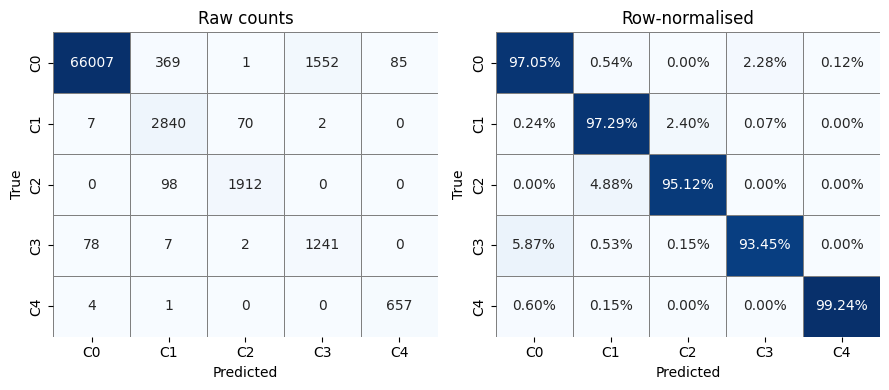

In [13]:
def plot_cm(cm, classes, title, normalise=False):
    if normalise:
        cm = cm / cm.sum(axis=1, keepdims=True)
        fmt, cmap = ".2%", "Blues"
    else:
        fmt, cmap = "d", "Blues"
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes,
                linewidths=.5, linecolor='grey')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title); plt.tight_layout()

plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plot_cm(cm,  [f"C{i}" for i in range(n_classes)],
                            "Raw counts", normalise=False)
plt.subplot(1,2,2); plot_cm(cm,  [f"C{i}" for i in range(n_classes)],
                            "Row-normalised", normalise=True)
plt.savefig("/mnt/data/cm_WSN-DS_dual.png", dpi=300)